In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from evaluation_reg import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, roc_curve, precision_score, f1_score,make_scorer
from sklearn.metrics import matthews_corrcoef
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
my_data = pd.read_csv('MAD_dataset_12.csv')

In [31]:
print(my_data.shape)

(371782, 1684)


In [32]:
np.random.seed(42)
df_0 = my_data[my_data.iloc[:,1] == 0]
df_1 = my_data[my_data.iloc[:,1] == 1]
#n_samples_per_class = round((len(my_data[my_data.iloc[:,1] == 1])))
n_samples_per_class = round((len(my_data[my_data.iloc[:,1] == 1])/10)*9)
train_0 = df_0.sample(n=n_samples_per_class, random_state=42)
train_1 = df_1.sample(n=n_samples_per_class, random_state=42)
train = pd.concat([train_0, train_1])
test = my_data.drop(train.index)
X_train = train.iloc[:, 2:]
y_train = train.iloc[:, 1]
X_test = test.iloc[:, 2:]
y_test = test.iloc[:, 1]

In [33]:
class DiabetesDataset(Dataset):
    def __init__(self,X,y):
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X.values)
        self.y_data = torch.from_numpy(y.values)
    def __getitem__(self, index):
        return self.x_data[index],self.y_data[index]
    def __len__(self):
        return self.len

train_dataset = DiabetesDataset(X_train,y_train)

# # weights = [6.8 if label == 1 else 1.7 for data, label in train_dataset]
# # sampler = WeightedRandomSampler(weights,num_samples=10, replacement=True)
# # train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
train_loader = DataLoader(dataset=train_dataset,batch_size=128,shuffle=True,num_workers=2,drop_last=True)
test_dataset = DiabetesDataset(X_test,y_test)
test_loader = DataLoader(dataset=test_dataset,batch_size=128,shuffle=True,num_workers=2,drop_last=True)


In [34]:
class GlycoproteinProphet(nn.Module):
    def __init__(self):
        super(GlycoproteinProphet, self).__init__()
        self.prot_fc1 = nn.Linear(1280, 64)
        self.prot_fc2 = nn.Linear(64, 32)
        self.prot_dropout1 = nn.Dropout(0.3)
        self.prot_dropout2 = nn.Dropout(0.2)
        self.bn_prot1 = nn.BatchNorm1d(64)
        self.bn_prot2 = nn.BatchNorm1d(32)
        self.activation_fn = nn.GELU()
        self.glycan_fc1 = nn.Linear(402, 64)
        self.glycan_lstm = nn.LSTM(128, 64, 2, batch_first=True)
        self.conv1 = nn.Conv1d(128, 64, 1)
        self.glycan_rnn = nn.RNN(64, 64, 2)
        self.glycan_f2 = nn.Linear(402, 32)
        self.bn_glycan1 = nn.BatchNorm1d(32)

        #self.bn_fc1 = nn.Linear(64, 32)
        #medthod1
        self.bn_fc1 = nn.Linear(64, 32)
        self.bn_fc2 = nn.Linear(32, 16)
        self.bn_fc3 = nn.Linear(16, 1)
        self.bn_relu = nn.ReLU()
        # Attention

        self.W_query = nn.Linear(402, 64)
        self.W_key = nn.Linear(402, 64)
        self.W_value = nn.Linear(402, 64)
        self.softmax = nn.Softmax(dim=1)
        self.attention_glycan_fc1 = nn.Linear(466, 32)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        prot_X_train_tensor = input[:, 0:1280].to(device)
        glycan_X_train_tensor = input[:, 1280:1684].to(device)
        prot_X_train_tensor = prot_X_train_tensor.float()
        glycan_X_train_tensor = glycan_X_train_tensor.float()
        x = self.prot_fc1(prot_X_train_tensor)
        prot1 = self.bn_prot1(self.prot_dropout1(x))
        prot2 = self.bn_prot2(self.prot_dropout2(self.prot_fc2(prot1)))
        #LSTM
        #glycan1,_= self.glycan_lstm(self.glycan_fc1(glycan_X_train_tensor))
        #glycan_X_train_tensor = glycan_X_train_tensor.transpose(0,1)
        # CNN
        # glycan1 = self.conv1(glycan_X_train_tensor)
        # glycan1 = glycan1.transpose(0, 1)
        # glycan1,_=self.glycan_rnn(glycan1)
        # glycan1 = glycan1.transpose(0, 1)
        # glycan1 = self.conv2(glycan1)
        # glycan1 = glycan1.transpose(0, 1)
        # glycan1 = self.conv1(self.glycan_fc1(glycan_X_train_tensor).transpose(0,1)).transpose(0,1)
        # #glycan2 = self.pool(glycan1).transpose(0,1)
        # #glycan2 = glycan2.view(glycan2.size(0), -1)
        # glycan3 = self.bn_glycan1(self.activation_fn(self.glycan_f2(glycan1)))
        # LSTM+RNN
        # glycan1, _ = self.glycan_lstm(glycan_X_train_tensor)
        # # glycan2,_ = self.glycan_rnn(glycan1)
        #glycan3 = self.bn_glycan1(self.glycan_f2(glycan1))
        # Attention
        query = self.W_query(glycan_X_train_tensor)
        key = self.W_key(glycan_X_train_tensor)
        value = self.W_value(glycan_X_train_tensor)
        key = key.transpose(0, 1)
        scores = torch.matmul(query, key)
        # attention_weights = torch.exp(scores)/torch.sum(scores, dim=1, keepdim=True)
        # attention_weights = self.softmax(scores)
        attention_weights = F.normalize(scores, p=2, dim=1)
        weighted_values = torch.matmul(attention_weights, value)
        #print(weighted_values.shape)
        glycan_feature = torch.cat((glycan_X_train_tensor, weighted_values), dim=1)
        glycan = self.attention_glycan_fc1(glycan_feature)
        #glycan = self.glycan_f2(glycan_X_train_tensor)
        h_n = torch.cat((prot2, glycan), 1)
        #x = F.sigmoid(self.bn_fc1(h_n))
        x = F.sigmoid(self.bn_fc3(self.bn_relu(self.bn_fc2(self.bn_relu(self.bn_fc1(h_n))))))
        #x = nn.functional.softmax(self.bn_fc3(self.bn_relu(self.bn_fc2(self.bn_relu(self.bn_fc1(h_n))))))
        return x

In [35]:
GlycoproteinProphet = GlycoproteinProphet().to(device)
# 定义损失函数和优化
criterion = nn.BCELoss().to(device)
#criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(GlycoproteinProphet.parameters(), lr=0.001)

# 学习率调度器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# 保存每个epoch的训练损失和验证损失


num_epochs = 200

In [36]:
train = []
for epoch in range(num_epochs):
    train_losses = []
    #train_pred = []
    #train_labels = []
    GlycoproteinProphet.train().to(device)
    for data in train_loader:
        optimizer.zero_grad()
        inputs,lables = data
        lables = lables.float().to(device)
        #lables = lables.type(torch.long).to(device)
        #lables = lables.to(device)
        #print(glycan_X_train_tensor.shape)
        outputs= GlycoproteinProphet(inputs).squeeze().to(device)
        #print(outputs)
        loss = criterion(outputs, lables).to(device)
        #print(epoch,loss.item())
        loss.backward()
        optimizer.step()
        #scheduler.step() # 更新学习率
        train_losses.append(loss.item())# 记录训练损失
        train.append(np.mean(train_losses))
    #scheduler.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(train_losses):.4f}')

Epoch [10/200], Loss: 0.3537
Epoch [20/200], Loss: 0.3286
Epoch [30/200], Loss: 0.3144
Epoch [40/200], Loss: 0.3063
Epoch [50/200], Loss: 0.2998
Epoch [60/200], Loss: 0.2941
Epoch [70/200], Loss: 0.2885
Epoch [80/200], Loss: 0.2834
Epoch [90/200], Loss: 0.2804
Epoch [100/200], Loss: 0.2764
Epoch [110/200], Loss: 0.2741
Epoch [120/200], Loss: 0.2711
Epoch [130/200], Loss: 0.2694
Epoch [140/200], Loss: 0.2660
Epoch [150/200], Loss: 0.2630
Epoch [160/200], Loss: 0.2620
Epoch [170/200], Loss: 0.2605
Epoch [180/200], Loss: 0.2583
Epoch [190/200], Loss: 0.2563
Epoch [200/200], Loss: 0.2548


In [37]:
result_test = []
lables_test = []
GlycoproteinProphet.eval().to(device)
with torch.no_grad():
    for data in test_loader:
        inputs, lables = data
        lables = lables.float().to(device)
        # print(glycan_X_train_tensor.shape)
        outputs = GlycoproteinProphet(inputs).squeeze().to(device)
        result_test.append(outputs.tolist())
        lables_test.append(lables.tolist())
my_result = [item for sublist in result_test for item in sublist]
my_labels = [item for sublist in lables_test for item in sublist]

In [38]:
my_test_pred_test = []
for i in my_result:
    if i > 0.5:
        my_test_pred_test.append(1)
    else:
        my_test_pred_test.append(0)

In [39]:
AUC = roc_auc_score(my_labels, my_test_pred_test)

In [40]:
AUC

0.8838429530525338

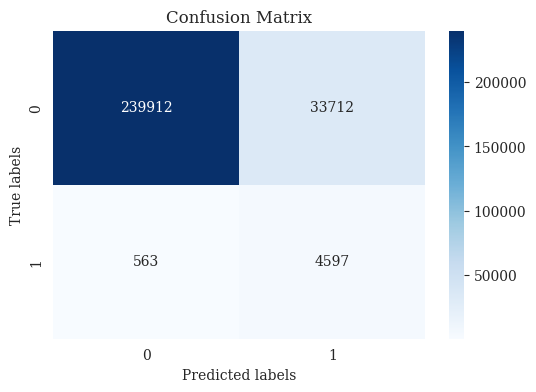

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(my_labels, my_test_pred_test)

# 使用seaborn库绘制彩色的混淆矩阵
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(6, 4))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix')
plt.show()

In [124]:
AUC5 = roc_auc_score(my_labels, my_test_pred_test)
fpr5, tpr5, _ = roc_curve(my_labels, my_result)

In [14]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [22]:
input = torch.rand(2, 3)
baseline = torch.zeros(2, 3)

In [25]:
baseline.shape

torch.Size([2, 3])

In [17]:
ig = IntegratedGradients(GlycoproteinProphet)

In [31]:
attr_list = []
for data in test_loader:
    inputs, lables = data
    lables = lables.float().unsqueeze(1).repeat(1, 1682).view(128, 1682)

    # 计算当前批次的 Integrated Gradients 和收敛性指标
    attr, delta = ig.attribute(inputs, lables, target=1, return_convergence_delta=True)
    attr = attr.detach().numpy()
    attr_list.append(attr)

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
features = {}

# 定义钩子函数
def hook_fn(module, input, output):
    # 把输出特征保存在字典中
    features['bn_fc2'] = output

# 给最后一个全连接层 (fc) 注册前向钩子
hook = GlycoproteinProphet.fc.register_forward_hook(hook_fn)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from sklearn import manifold
def visual(feat):
    ts = manifold.TSNE(n_components=2, init='pca', random_state=0)
    x_ts = ts.fit_transform(feat)
    print(x_ts.shape)
    x_min, x_max = x_ts.min(0), x_ts.max(0)
    x_final = (x_ts - x_min) / (x_max - x_min)
    return x_final
maker = ['o', 'o', '^', 's', 'p', '*', '<', '>', 'D', 'd', 'h', 'H']
colors = ['#629433', '#BE7FB8', '#99a4bc', 'cyan', 'blue', 'lime', 'r', 'violet', 'm', 'peru', 'olivedrab',
          'hotpink']
Label_Com = ['a', 'b', 'c', 'd']
font1 = {'family': 'Times New Roman',
         'weight': 'bold',
         'size': 32,
         }
def plotlabels(S_lowDWeights, Trure_labels, name):
    True_labels = Trure_labels.iloc[:,1].values.reshape((-1, 1))
    S_data = np.hstack((S_lowDWeights, True_labels))
    S_data = pd.DataFrame({'x': S_data[:, 0], 'y': S_data[:, 1], 'label': S_data[:, 2]})
    print(S_data)
    print(S_data.shape)

    for index in range(2):  # 假设总共有三个类别，类别的表示为0,1,2
        X = S_data.loc[S_data['label'] == index]['x']
        Y = S_data.loc[S_data['label'] == index]['y']
        plt.scatter(X, Y, marker=maker[index], c=colors[index], edgecolors=colors[index])
        plt.plot([], [], marker=maker[index], color=colors[index], label=f'{index}')

        plt.xlabel('Dim1')
        plt.ylabel('Dim2')


    plt.title(name, fontsize=10)
    plt.legend()


fig = plt.figure(figsize=(6, 4))

plotlabels(visual(my_feature), y_test, 'CppNet(ESM-2+LSTM+FP)')

plt.show(fig)
plt.savefig('CppNet(ESM-2+LSTM+FP).pdf')

In [ ]:
columns_to_sum = ['A', 'B', 'C', 'D', 'E']

# 将选择的列相加，结果存储在新列 '4p' 中
df['4p'] = df[columns_to_sum].sum(axis=1)